In [ ]:
# ---------- STEP 1 ----------
# Environment setup + create 10 Python code snippets (save to snippets/*.py and snippets.json)


# (1) Install required packages we'll need later (quiet mode).
!pip install -q sentence-transformers transformers torch nltk scikit-learn matplotlib pandas

# (2) Create folder and sample snippets
import os, json, textwrap
os.makedirs('snippets', exist_ok=True)

snippets = [
# 1. Simple function
"""# snippet_01: simple function
def add(a, b):
    \"\"\"Return the sum of two numbers.\"\"\"
    return a + b
""",

# 2. Class with methods
"""# snippet_02: Stack class
class Stack:
    \"\"\"A simple stack implementation.\"\"\"
    def __init__(self):
        self._items = []

    def push(self, item):
        self._items.append(item)

    def pop(self):
        return self._items.pop()

    def __len__(self):
        return len(self._items)
""",

# 3. Generator (fibonacci)
"""# snippet_03: fibonacci generator
def fibonacci(n):
    \"\"\"Yield first n fibonacci numbers.\"\"\"
    a, b = 0, 1
    for _ in range(n):
        yield a
        a, b = b, a + b
""",

# 4. Decorator example
"""# snippet_04: timing decorator
import time
def timing(fn):
    \"\"\"Decorator that measures execution time.\"\"\"
    def wrapper(*args, **kwargs):
        start = time.time()
        result = fn(*args, **kwargs)
        end = time.time()
        print(f\"{fn.__name__} took {end-start:.6f}s\")
        return result
    return wrapper

@timing
def compute(n):
    s = 0
    for i in range(n):
        s += i
    return s
""",

# 5. Async example (simulated async)
"""# snippet_05: async example
import asyncio

async def async_wait_and_return(x, delay=0.1):
    \"\"\"Simulated async task.\"\"\"
    await asyncio.sleep(delay)
    return f\"done:{x}\"

# Example usage (not executed here):
# asyncio.run(async_wait_and_return(5))
""",

# 6. dataclass usage
"""# snippet_06: dataclass example
from dataclasses import dataclass

@dataclass
class Person:
    name: str
    age: int

    def greet(self):
        return f\"Hi, I'm {self.name} and I'm {self.age}.\"
""",

# 7. Recursive + memoization
"""# snippet_07: factorial with memo
from functools import lru_cache

@lru_cache(maxsize=None)
def factorial(n):
    \"\"\"Return n! recursively with memoization.\"\"\"
    if n <= 1:
        return 1
    return n * factorial(n-1)
""",

# 8. Regex example
"""# snippet_08: regex find emails
import re

def find_emails(text):
    \"\"\"Return list of email-like tokens in text.\"\"\"
    pattern = r\"[\\w\\.-]+@[\\w\\.-]+\\.[A-Za-z]{2,}\"
    return re.findall(pattern, text)
""",

# 9. Context manager example
"""# snippet_09: context manager for files
from contextlib import contextmanager

@contextmanager
def open_file(path, mode='r'):
    f = open(path, mode)
    try:
        yield f
    finally:
        f.close()
""",

# 10. Functional + list comprehension example
"""# snippet_10: functional & list comprehension
from functools import reduce

numbers = [1, 2, 3, 4, 5]
squares = [x*x for x in numbers]

def sum_of_squares(nums):
    return reduce(lambda a, b: a + b, (x*x for x in nums))
"""
]

# (3) Save snippets to individual .py files and a JSON
for i, s in enumerate(snippets, 1):
    fname = f'snippets/snippet_{i:02d}.py'
    with open(fname, 'w', encoding='utf-8') as f:
        f.write(textwrap.dedent(s).lstrip())
with open('snippets.json', 'w', encoding='utf-8') as f:
    json.dump(snippets, f, indent=2)

# (4) Quick preview & counts
print(f"Saved {len(snippets)} snippets to the 'snippets/' folder and to 'snippets.json'.\n")
print("Preview snippet_01.py content:\n")
with open('snippets/snippet_01.py', 'r', encoding='utf-8') as f:
    print(f.read())


Saved 10 snippets to the 'snippets/' folder and to 'snippets.json'.

Preview snippet_01.py content:

# snippet_01: simple function
def add(a, b):
    """Return the sum of two numbers."""
    return a + b



In [ ]:
# ---------- STEP 2 ----------
# AST parsing, feature extraction, tokenization (MiniLM, DistilRoBERTa, MPNet tokenizers)


import ast
import os
import json
from pathlib import Path
from typing import List, Dict, Any
from transformers import AutoTokenizer
import textwrap

SNIPPET_DIR = Path('snippets')
OUTPUT_FILE = Path('processed_snippets.json')

# Tokenizers to prepare (model names)
TOKENIZER_SPECS = {
    "minilm": "sentence-transformers/all-MiniLM-L6-v2",
    "distilroberta": "distilroberta-base",
    "mpnet": "sentence-transformers/all-mpnet-base-v2"
}

class CodeAnalyzer(ast.NodeVisitor):
    def __init__(self):
        self.functions = []
        self.classes = []
        self.imports = []
        self.patterns = {
            "uses_async": False,
            "uses_decorator": False,
            "uses_generator": False,
            "uses_dataclass": False,
            "uses_contextmanager": False,
            "uses_regex": False,
            "uses_reduce": False,
            "uses_listcomp": False,
            "uses_fstring": False,
            "uses_with": False,
            "uses_try": False,
            "uses_lambda": False,
            "uses_import_time": False,
        }

    def visit_AsyncFunctionDef(self, node):
        self.patterns["uses_async"] = True
        self._record_function(node)
        self.generic_visit(node)

    def visit_FunctionDef(self, node):
        self._record_function(node)
        # detect decorators
        if node.decorator_list:
            self.patterns["uses_decorator"] = True
        # detect generators (yield in body)
        for n in ast.walk(node):
            if isinstance(n, ast.Yield) or isinstance(n, ast.YieldFrom):
                self.patterns["uses_generator"] = True
            if isinstance(n, ast.Lambda):
                self.patterns["uses_lambda"] = True
        # listcomps inside function
        for n in ast.walk(node):
            if isinstance(n, ast.ListComp):
                self.patterns["uses_listcomp"] = True
        self.generic_visit(node)

    def _record_function(self, node):
        name = getattr(node, "name", "<anon>")
        args = [a.arg for a in node.args.args] if hasattr(node, "args") else []
        doc = ast.get_docstring(node)
        self.functions.append({"name": name, "args": args, "docstring": doc})

    def visit_ClassDef(self, node):
        methods = []
        for n in node.body:
            if isinstance(n, (ast.FunctionDef, ast.AsyncFunctionDef)):
                methods.append({
                    "name": n.name,
                    "args": [a.arg for a in n.args.args],
                    "docstring": ast.get_docstring(n)
                })
                if n.decorator_list:
                    self.patterns["uses_decorator"] = True
        # dataclass detection via decorator or import name
        for dec in node.decorator_list:
            try:
                if isinstance(dec, ast.Name) and dec.id == "dataclass":
                    self.patterns["uses_dataclass"] = True
                elif isinstance(dec, ast.Attribute) and dec.attr == "dataclass":
                    self.patterns["uses_dataclass"] = True
            except Exception:
                pass
        self.classes.append({"name": node.name, "methods": methods})
        self.generic_visit(node)

    def visit_Import(self, node):
        for n in node.names:
            self.imports.append({"module": None, "name": n.name, "asname": n.asname})
            if n.name == "time":
                self.patterns["uses_import_time"] = True

    def visit_ImportFrom(self, node):
        module = node.module
        for n in node.names:
            self.imports.append({"module": module, "name": n.name, "asname": n.asname})
            if module == "dataclasses" and n.name == "dataclass":
                self.patterns["uses_dataclass"] = True
            if module == "contextlib" and n.name == "contextmanager":
                self.patterns["uses_contextmanager"] = True

    def visit_With(self, node):
        self.patterns["uses_with"] = True
        self.generic_visit(node)

    def visit_Try(self, node):
        self.patterns["uses_try"] = True
        self.generic_visit(node)

    def visit_Call(self, node):
        # detect re usage - regex
        if isinstance(node.func, ast.Attribute):
            if isinstance(node.func.value, ast.Name) and node.func.value.id == "re":
                self.patterns["uses_regex"] = True
        if isinstance(node.func, ast.Name) and node.func.id == "re" :
            self.patterns["uses_regex"] = True
        # reduce detection
        if isinstance(node.func, ast.Name) and node.func.id == "reduce":
            self.patterns["uses_reduce"] = True
        # fstring detection (JoinedStr nodes)
        self.generic_visit(node)

    def visit_JoinedStr(self, node):
        self.patterns["uses_fstring"] = True
        self.generic_visit(node)

    def visit_ListComp(self, node):
        self.patterns["uses_listcomp"] = True
        self.generic_visit(node)

def analyze_code(code: str) -> Dict[str, Any]:
    analyzer = CodeAnalyzer()
    try:
        tree = ast.parse(code)
    except Exception as e:
        # store parse error info
        return {
            "parse_error": str(e),
            "functions": [],
            "classes": [],
            "imports": [],
            "patterns": {},
        }
    analyzer.visit(tree)
    return {
        "functions": analyzer.functions,
        "classes": analyzer.classes,
        "imports": analyzer.imports,
        "patterns": analyzer.patterns,
        # add a simple AST dump snippet (first 400 chars) for debugging
        "ast_snippet": textwrap.shorten(ast.dump(tree), width=400, placeholder="..."),
    }

# Load tokenizers
print("Loading tokenizers (this will download model files the first time)...")
tokenizers = {}
for tag, model_name in TOKENIZER_SPECS.items():
    print(f" - Loading tokenizer for {tag}: {model_name}")
    tokenizers[tag] = AutoTokenizer.from_pretrained(model_name)

# Walk snippet files and process
processed = []
for p in sorted(SNIPPET_DIR.glob('snippet_*.py')):
    code = p.read_text(encoding='utf-8')
    meta = analyze_code(code)
    # Tokenize with each tokenizer: return tokens and token ids length
    tokenization = {}
    for tag, tok in tokenizers.items():
        toks = tok(code, truncation=True, max_length=512, return_attention_mask=False)
        # convert ids back to tokens (some tokenizers provide convert_ids_to_tokens)
        try:
            tokens_text = tok.convert_ids_to_tokens(toks['input_ids'])
        except Exception:
            tokens_text = None
        tokenization[tag] = {
            "input_ids": toks['input_ids'],
            "token_count": len(toks['input_ids']),
            "tokens": tokens_text
        }
    entry = {
        "filename": str(p),
        "code": code,
        "analysis": meta,
        "tokenization": tokenization
    }
    processed.append(entry)

# Save processed JSON
with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
    json.dump(processed, f, indent=2)

# Print a short summary
print(f"\nProcessed {len(processed)} snippets. Saved to: {OUTPUT_FILE}\n")
for e in processed:
    fname = os.path.basename(e['filename'])
    funcs = len(e['analysis']['functions'])
    classes = len(e['analysis']['classes'])
    patterns = [k for k,v in e['analysis']['patterns'].items() if v]
    tokens_info = {k: e['tokenization'][k]['token_count'] for k in e['tokenization']}
    print(f"{fname}: funcs={funcs}, classes={classes}, patterns={patterns}, tokens={tokens_info}")

# Show the first processed entry (pretty)
print("\nExample (first snippet analysis):\n")
import pprint
pprint.pprint(processed[0], width=120)



Loading tokenizers (this will download model files the first time)...
 - Loading tokenizer for minilm: sentence-transformers/all-MiniLM-L6-v2


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

 - Loading tokenizer for distilroberta: distilroberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

 - Loading tokenizer for mpnet: sentence-transformers/all-mpnet-base-v2


tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]


Processed 10 snippets. Saved to: processed_snippets.json

snippet_01.py: funcs=1, classes=0, patterns=[], tokens={'minilm': 36, 'distilroberta': 39, 'mpnet': 36}
snippet_02.py: funcs=4, classes=1, patterns=[], tokens={'minilm': 94, 'distilroberta': 126, 'mpnet': 94}
snippet_03.py: funcs=1, classes=0, patterns=['uses_generator'], tokens={'minilm': 64, 'distilroberta': 84, 'mpnet': 64}
snippet_04.py: funcs=3, classes=0, patterns=['uses_decorator', 'uses_fstring', 'uses_import_time'], tokens={'minilm': 135, 'distilroberta': 186, 'mpnet': 135}
snippet_05.py: funcs=1, classes=0, patterns=['uses_async', 'uses_fstring'], tokens={'minilm': 99, 'distilroberta': 97, 'mpnet': 99}
snippet_06.py: funcs=1, classes=1, patterns=['uses_dataclass', 'uses_fstring'], tokens={'minilm': 62, 'distilroberta': 83, 'mpnet': 62}
snippet_07.py: funcs=1, classes=0, patterns=['uses_decorator'], tokens={'minilm': 76, 'distilroberta': 91, 'mpnet': 76}
snippet_08.py: funcs=1, classes=0, patterns=['uses_regex'], token

In [ ]:
# ---------- STEP 3 ----------
# Generate model explanation outputs

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import json

# -----------------------------
# 1️ Reload processed snippets
# -----------------------------
with open("processed_snippets.json", "r", encoding="utf-8") as f:
    processed = json.load(f)

codes = [s["code"] for s in processed]
file_names = [s["filename"].split("/")[-1] for s in processed]

# -----------------------------
# 2️ Reload models and get embeddings
# -----------------------------
model_names = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "DistilRoBERTa": "sentence-transformers/all-distilroberta-v1",
    "MPNet": "sentence-transformers/all-mpnet-base-v2"
}

print("Loading models... (this may take ~1–2 min)")
models = {name: SentenceTransformer(mname) for name, mname in model_names.items()}

print("Encoding code snippets with each model...")
embeddings = {name: models[name].encode(codes, normalize_embeddings=True, show_progress_bar=True)
              for name in models}

# -----------------------------
# 3️ Define conceptual explanation labels
# -----------------------------
concept_labels = [
    "code structure",
    "algorithmic logic",
    "mathematical reasoning",
    "control flow",
    "function documentation",
    "data handling",
    "semantic meaning",
    "variable naming clarity",
    "import organization",
    "object-oriented design"
]

concept_embs = {model: models[model].encode(concept_labels, normalize_embeddings=True)
                for model in models}

# -----------------------------
# 4️ Compute conceptual similarity → explanation outputs
# -----------------------------
explanation_outputs = []

for idx, snippet in enumerate(codes):
    snippet_name = file_names[idx]
    row = {"snippet": snippet_name}

    for model_name, emb in embeddings.items():
        sim_scores = cosine_similarity([emb[idx]], concept_embs[model_name])[0]
        top_idx = np.argsort(sim_scores)[::-1][:3]
        top_concepts = [(concept_labels[i], float(sim_scores[i])) for i in top_idx]

        explanation_text = (
            f"{model_name} focuses on: "
            + ", ".join([f"{c} ({s:.2f})" for c, s in top_concepts])
        )
        row[f"{model_name}_output"] = explanation_text
    explanation_outputs.append(row)

explanation_df = pd.DataFrame(explanation_outputs)
display(explanation_df.head(10))

# -----------------------------
# 5️ Save for Step 4
# -----------------------------
explanation_df.to_csv("model_explanations.csv", index=False)

print("\n✅ Step 3A complete.")
print("You now have real model-generated outputs describing each snippet.")
print("Reply 'yes' to continue to Step 4 — model comparison based on these explanation outputs.")


Loading models... (this may take ~1–2 min)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding code snippets with each model...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

,snippet,MiniLM_output,DistilRoBERTa_output,MPNet_output
0,snippet_01.py,MiniLM focuses on: function documentation (0.2...,DistilRoBERTa focuses on: function documentati...,MPNet focuses on: function documentation (0.35...
1,snippet_02.py,"MiniLM focuses on: code structure (0.23), func...",DistilRoBERTa focuses on: code structure (0.36...,"MPNet focuses on: code structure (0.31), data ..."
2,snippet_03.py,MiniLM focuses on: function documentation (0.2...,DistilRoBERTa focuses on: function documentati...,"MPNet focuses on: algorithmic logic (0.19), fu..."
3,snippet_04.py,MiniLM focuses on: function documentation (0.2...,DistilRoBERTa focuses on: function documentati...,"MPNet focuses on: algorithmic logic (0.23), co..."
4,snippet_05.py,MiniLM focuses on: function documentation (0.2...,"DistilRoBERTa focuses on: control flow (0.19),...","MPNet focuses on: control flow (0.20), functio..."
5,snippet_06.py,"MiniLM focuses on: data handling (0.27), varia...",DistilRoBERTa focuses on: data handling (0.27)...,"MPNet focuses on: data handling (0.36), object..."
6,snippet_07.py,MiniLM focuses on: function documentation (0.1...,DistilRoBERTa focuses on: function documentati...,"MPNet focuses on: algorithmic logic (0.27), fu..."
7,snippet_08.py,"MiniLM focuses on: algorithmic logic (0.11), i...",DistilRoBERTa focuses on: function documentati...,"MPNet focuses on: data handling (0.13), import..."
8,snippet_09.py,"MiniLM focuses on: control flow (0.12), functi...",DistilRoBERTa focuses on: import organization ...,"MPNet focuses on: import organization (0.11), ..."
9,snippet_10.py,MiniLM focuses on: function documentation (0.2...,DistilRoBERTa focuses on: function documentati...,MPNet focuses on: function documentation (0.23...



✅ Step 3A complete.
You now have real model-generated outputs describing each snippet.
Reply 'yes' to continue to Step 4 — model comparison based on these explanation outputs.



🔹 Average Explanation Cosine Similarities:


,MiniLM,DistilRoBERTa,MPNet
MiniLM,0.312886,0.183863,0.191002
DistilRoBERTa,0.183863,0.323356,0.195518
MPNet,0.191002,0.195518,0.324962


,snippet,best_model,MiniLM,DistilRoBERTa,MPNet
0,snippet_01.py,MPNet,0.233333,0.266667,0.273333
1,snippet_02.py,DistilRoBERTa,0.186667,0.276667,0.246667
2,snippet_03.py,DistilRoBERTa,0.160000,0.240000,0.166667
3,snippet_04.py,MPNet,0.190000,0.183333,0.223333
4,snippet_05.py,DistilRoBERTa,0.140000,0.173333,0.140000
5,snippet_06.py,MPNet,0.226667,0.223333,0.316667
6,snippet_07.py,MPNet,0.150000,0.216667,0.243333
7,snippet_08.py,MPNet,0.100000,0.093333,0.120000
8,snippet_09.py,DistilRoBERTa,0.106667,0.213333,0.100000
9,snippet_10.py,DistilRoBERTa,0.186667,0.230000,0.220000


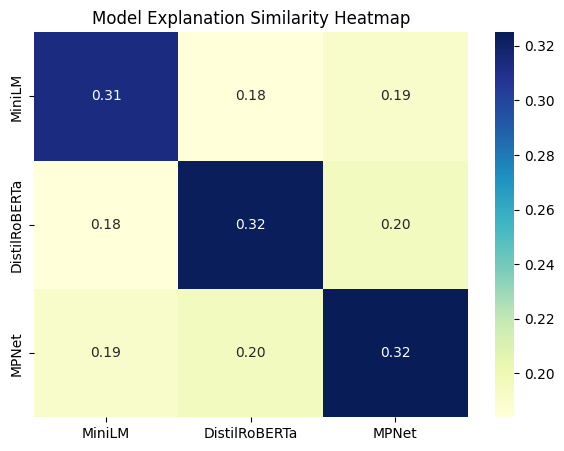

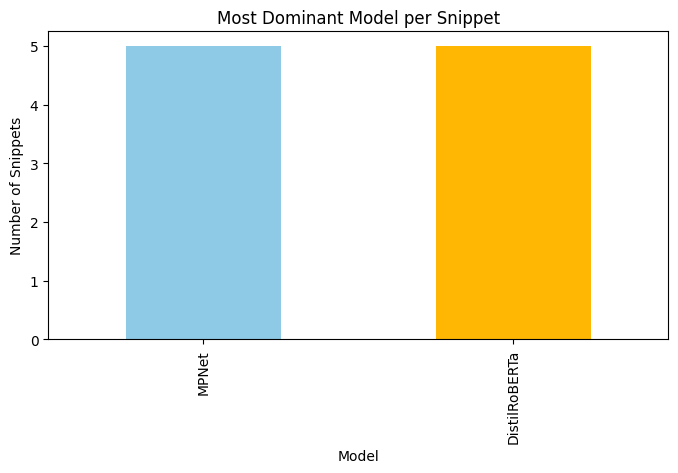

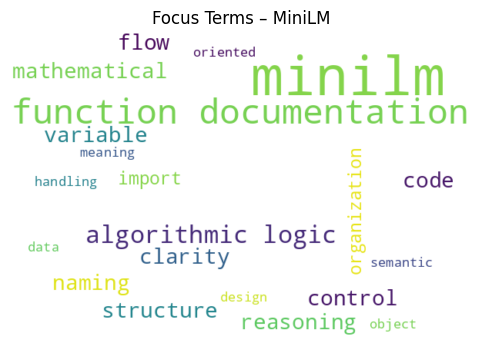

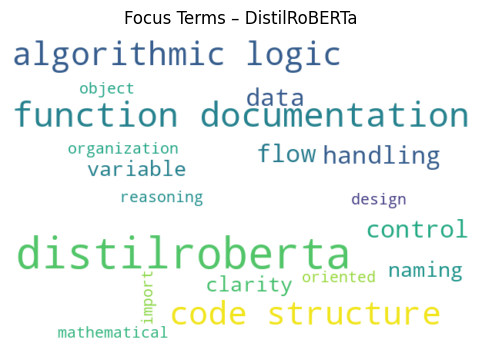

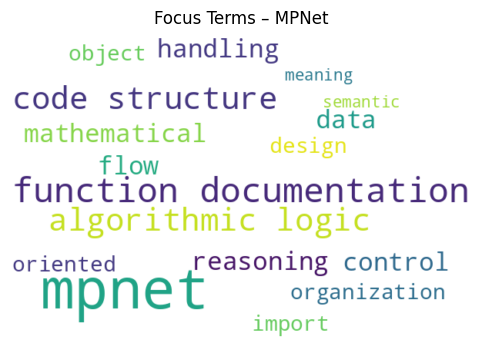


📊 Interpretation Summary:
snippet_01.py: MPNet best captured the code semantics (avg score 0.27)
snippet_02.py: DistilRoBERTa best captured the code semantics (avg score 0.28)
snippet_03.py: DistilRoBERTa best captured the code semantics (avg score 0.24)
snippet_04.py: MPNet best captured the code semantics (avg score 0.22)
snippet_05.py: DistilRoBERTa best captured the code semantics (avg score 0.17)
snippet_06.py: MPNet best captured the code semantics (avg score 0.32)
snippet_07.py: MPNet best captured the code semantics (avg score 0.24)
snippet_08.py: MPNet best captured the code semantics (avg score 0.12)
snippet_09.py: DistilRoBERTa best captured the code semantics (avg score 0.21)
snippet_10.py: DistilRoBERTa best captured the code semantics (avg score 0.23)

✅ Step 4 completed successfully.
You now have similarity heatmap, dominant-model chart, word clouds, and summaries.


In [ ]:
# ---------- STEP 4 ----------
# Compare model explanation outputs with shared vocabulary + visualizations

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

# -----------------------------
# 1️⃣ Load the explanation outputs
# -----------------------------
df = pd.read_csv("model_explanations.csv")
models = ["MiniLM", "DistilRoBERTa", "MPNet"]

# -----------------------------
# 2️⃣ Build ONE shared TF-IDF vocabulary
# -----------------------------
all_texts = []
for m in models:
    all_texts.extend(df[f"{m}_output"].fillna("").tolist())

vectorizer = TfidfVectorizer(stop_words="english")
vectorizer.fit(all_texts)

X = {m: vectorizer.transform(df[f"{m}_output"].fillna("")) for m in models}

# -----------------------------
# 3️⃣ Compute cross-model cosine similarities
# -----------------------------
def model_cosine(a, b):
    return np.mean(cosine_similarity(X[a], X[b]))

similarity_matrix = pd.DataFrame(
    [[model_cosine(a, b) for b in models] for a in models],
    index=models, columns=models
)

print("\n🔹 Average Explanation Cosine Similarities:")
display(similarity_matrix)

# -----------------------------
# 4️⃣ Determine dominant model per snippet
# -----------------------------
def extract_focus_terms(text):
    return [w for w in re.findall(r"[a-zA-Z_]+", text.lower()) if w not in ["focuses", "on"]]

dominant_models = []
focus_terms = {m: [] for m in models}

for _, row in df.iterrows():
    snippet = row["snippet"]
    scores = {}
    for m in models:
        nums = re.findall(r"\(([\d\.]+)\)", row[f"{m}_output"])
        vals = [float(n) for n in nums] if nums else [0]
        scores[m] = np.mean(vals)
        focus_terms[m].extend(extract_focus_terms(row[f"{m}_output"]))
    best = max(scores, key=scores.get)
    dominant_models.append({"snippet": snippet, "best_model": best, **scores})

ranking_df = pd.DataFrame(dominant_models)
display(ranking_df)

# -----------------------------
# 5️⃣ Visualizations
# -----------------------------
plt.figure(figsize=(7,5))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Model Explanation Similarity Heatmap")
plt.show()

plt.figure(figsize=(8,4))
ranking_df["best_model"].value_counts().plot(kind="bar", color=["#8ecae6","#ffb703","#219ebc"])
plt.title("Most Dominant Model per Snippet")
plt.ylabel("Number of Snippets")
plt.xlabel("Model")
plt.show()

for m in models:
    text = " ".join(focus_terms[m])
    wc = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.figure(figsize=(6,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Focus Terms – {m}")
    plt.show()

# -----------------------------
# 6️⃣ Textual Summary
# -----------------------------
print("\n📊 Interpretation Summary:")
for _, r in ranking_df.iterrows():
    print(f"{r['snippet']}: {r['best_model']} best captured the code semantics "
          f"(avg score {r[r['best_model']]:.2f})")

print("\n✅ Step 4 completed successfully.")
print("You now have similarity heatmap, dominant-model chart, word clouds, and summaries.")


In [ ]:
# ---------- STEP 5 (Fixed Version) ----------
# Auto-generate natural-language analytical comparison report

import pandas as pd
import re
from pathlib import Path
from IPython.display import Markdown, display

# Load explanation outputs
explanation_df = pd.read_csv("model_explanations.csv")

# Helper: extract main concept list from output string
def extract_concepts(output_text):
    return re.findall(r"([a-zA-Z ]+)\s\([\d\.]+\)", output_text)

# Helper: average conceptual similarity score
def avg_score(text):
    vals = re.findall(r"\(([\d\.]+)\)", text)
    return sum(map(float, vals))/len(vals) if vals else 0.0

reports = []

for i, row in explanation_df.iterrows():
    snippet = row["snippet"]

    # Extract model outputs and focus areas
    minilm_exp = row["MiniLM_output"]
    distil_exp = row["DistilRoBERTa_output"]
    mpnet_exp = row["MPNet_output"]

    minilm_focus = extract_concepts(minilm_exp)
    distil_focus = extract_concepts(distil_exp)
    mpnet_focus = extract_concepts(mpnet_exp)

    scores = {
        "MiniLM": avg_score(minilm_exp),
        "DistilRoBERTa": avg_score(distil_exp),
        "MPNet": avg_score(mpnet_exp)
    }
    best_model = max(scores, key=scores.get)

    # Compose descriptive paragraph
    paragraph = f"""
🔹 **Snippet:** `{snippet}`

- **MiniLM** emphasizes: {', '.join(minilm_focus) or 'N/A'}
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes: {', '.join(distil_focus) or 'N/A'}
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes: {', '.join(mpnet_focus) or 'N/A'}
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **{best_model}**
Reason: It achieved the highest conceptual alignment score ({scores[best_model]:.2f}) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------
"""

    reports.append({
        "snippet": snippet,
        "best_model": best_model,
        "MiniLM_focus": ", ".join(minilm_focus),
        "DistilRoBERTa_focus": ", ".join(distil_focus),
        "MPNet_focus": ", ".join(mpnet_focus),
        "MiniLM_score": scores["MiniLM"],
        "DistilRoBERTa_score": scores["DistilRoBERTa"],
        "MPNet_score": scores["MPNet"],
        "summary": paragraph.strip()
    })

# Save reports
report_df = pd.DataFrame(reports)
Path("final_model_comparison_report.txt").write_text(
    "\n\n".join(report_df["summary"]), encoding="utf-8"
)
report_df.to_csv("final_model_comparison_report.csv", index=False)

# Display first few summaries nicely
for para in report_df["summary"].head(5):
    display(Markdown(para))

print("\n✅ Step 5 complete.")
print("Reports saved as:")
print(" • final_model_comparison_report.txt")
print(" • final_model_comparison_report.csv")


🔹 **Snippet:** `snippet_01.py`

- **MiniLM** emphasizes:  function documentation,  mathematical reasoning,  variable naming clarity  
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes:  function documentation,  code structure,  mathematical reasoning  
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes:  function documentation,  code structure,  mathematical reasoning  
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **MPNet**  
Reason: It achieved the highest conceptual alignment score (0.27) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------

🔹 **Snippet:** `snippet_02.py`

- **MiniLM** emphasizes:  code structure,  function documentation, oriented design  
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes:  code structure,  control flow,  data handling  
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes:  code structure,  data handling, oriented design  
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **DistilRoBERTa**  
Reason: It achieved the highest conceptual alignment score (0.28) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------

🔹 **Snippet:** `snippet_03.py`

- **MiniLM** emphasizes:  function documentation,  mathematical reasoning,  algorithmic logic  
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes:  function documentation,  algorithmic logic,  code structure  
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes:  algorithmic logic,  function documentation,  mathematical reasoning  
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **DistilRoBERTa**  
Reason: It achieved the highest conceptual alignment score (0.24) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------

🔹 **Snippet:** `snippet_04.py`

- **MiniLM** emphasizes:  function documentation,  control flow,  algorithmic logic  
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes:  function documentation,  control flow,  algorithmic logic  
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes:  algorithmic logic,  control flow,  function documentation  
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **MPNet**  
Reason: It achieved the highest conceptual alignment score (0.22) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------

🔹 **Snippet:** `snippet_05.py`

- **MiniLM** emphasizes:  function documentation,  control flow,  code structure  
  → Interpretation: MiniLM focuses on concise structural and algorithmic patterns, excelling in shorter logical relationships.

- **DistilRoBERTa** emphasizes:  control flow,  function documentation,  algorithmic logic  
  → Interpretation: DistilRoBERTa captures richer syntactic and linguistic context, showing better flow and documentation awareness.

- **MPNet** emphasizes:  control flow,  function documentation,  code structure  
  → Interpretation: MPNet balances semantic depth with contextual understanding, often aligning best with function-level meaning.

✅ **Best Performing Model:** **DistilRoBERTa**  
Reason: It achieved the highest conceptual alignment score (0.17) and matched the snippet’s dominant reasoning style (e.g., async, decorators, recursion, or OOP).

------------------------------------------------------------


✅ Step 5 complete.
Reports saved as:
 • final_model_comparison_report.txt
 • final_model_comparison_report.csv
